In [1]:
import gc
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from atmacup_18 import constants

import utils

importlib.reload(utils)

<module 'utils' from '/home/tatsuya/projects/atmacup/atmacup_18/experiments/main/v00/v00_18_07/utils.py'>

In [2]:
RANDOM_STATE = 2024
utils.seed_everything(RANDOM_STATE)

## データ読み込み

In [3]:
notebook_dir = Path().resolve()
DATA_DIR = notebook_dir.parents[3].joinpath("data")
DATASET_DIR = DATA_DIR.joinpath("atmaCup#18_dataset")
TR_FEATURES_CSV = DATASET_DIR.joinpath("train_features.csv")
TS_FEATURES_CSV = DATASET_DIR.joinpath("test_features.csv")
IMAGES_DIR = DATASET_DIR.joinpath("images")
TRAFFIC_LIGHTS_CSV = DATASET_DIR.joinpath("traffic_lights.csv")

IMAGE_NAMES = ["image_t.png", "image_t-0.5.png", "image_t-1.0.png"]
TRAFFIC_LIGHTS_BBOX_IMAGE_NAME = constants.TRAFFIC_LIGHT_BBOX_IMAGE_NAME
OPTICAL_FLOW_IMAGE_NAME = constants.OPTICAL_FLOW_IMAGE_NAME

BASE_PRED_DIR = Path("..", "..", "..", "main2", "v00", "v00_04_00")
BASE_OOF_PRED_CSV = BASE_PRED_DIR.joinpath("oof_preds.csv")
BASE_SUBMISSION_CSV = BASE_PRED_DIR.joinpath("submission.csv")

In [4]:
TARGET_COLS = sum([[f"x_{i}", f"y_{i}", f"z_{i}"] for i in range(6)], [])

In [5]:
tr_df = utils.read_feature_csv(TR_FEATURES_CSV)
tr_df.head(2)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,scene_id,scene_dsec,origin_idx
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32,i64
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079,"""00066be8e20318869c38c66be46663…",320,0
"""00066be8e20318869c38c66be46663…",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,4.970268,-0.007936,0.005028,10.350489,-0.032374,-0.020701,15.770054,0.084073,0.008645,21.132415,0.391343,0.036335,26.316489,0.843124,0.065,31.383814,1.42507,0.073083,"""00066be8e20318869c38c66be46663…",420,1


In [6]:
ts_df = utils.read_feature_csv(TS_FEATURES_CSV)
ts_df.head(2)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,scene_id,scene_dsec,origin_idx
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,str,i32,i64
"""012baccc145d400c896cb82065a93d…",3.374273,-0.01936,-34.008415,17.0,0.0,false,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",120,0
"""012baccc145d400c896cb82065a93d…",2.441048,-0.022754,307.860077,295.0,0.0,true,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",220,1


In [7]:
def reduce_base_pred(
    df: pl.DataFrame, base_pred_df: pl.DataFrame, has_target: bool
) -> pl.DataFrame:
    """
    基礎推定値のdfをconcatし、元のdfのtarget列から除去したdfを返す

    Args:
        df (pl.DataFrame): target列を持つDataFrame
        base_pred_df (pl.DataFrame): 基礎推定値のDataFrame
        has_target (bool): target列を持つかどうか
    """
    pf = "base_pred_"
    df = pl.concat(
        [df, base_pred_df.select(pl.all().name.prefix(pf))], how="horizontal"
    )

    if has_target:
        target_cols = TARGET_COLS
        df = df.with_columns(
            [
                (pl.col(tg_col) - pl.col(f"{pf}{tg_col}")).alias(tg_col)
                for tg_col in target_cols
            ]
        )
    return df


def add_base_pred_to_target(df: pl.DataFrame, target_cols: list[str]) -> pl.DataFrame:
    """
    target_colsの列に基礎推定量を足したDataFrameを返す

    Args:
        df (pl.DataFrame): target列を持つDataFrame
        target_cols (list[str]): 追加する基礎推定量の列名
    """
    pf = "base_pred_"
    base_pred_cols = [f"{pf}{tg_col}" for tg_col in TARGET_COLS]
    df = df.with_columns(
        [
            (pl.col(tg_col) + pl.col(bp_col)).alias(tg_col)
            for tg_col, bp_col in zip(target_cols, base_pred_cols)
        ]
    )

    return df


if BASE_PRED_DIR is not None:
    # columns: "x_0", "y_0", "z_0", ..., "x_5", "y_5", "z_5"
    base_oof_pred_df = pl.read_csv(BASE_OOF_PRED_CSV)
    base_submission_df = pl.read_csv(BASE_SUBMISSION_CSV)

    # 基礎推定値を元のtarget列から引いた値を新たなtarget列とする
    tr_df = reduce_base_pred(tr_df, base_oof_pred_df, has_target=True)
    ts_df = reduce_base_pred(ts_df, base_submission_df, has_target=False)

    del base_oof_pred_df
    gc.collect()

    del base_submission_df
    gc.collect()

In [8]:
tr_tl_bbox_images = utils.load_npy_images(
    IMAGES_DIR,
    ids=tr_df.get_column("ID").to_list(),
    image_names=[TRAFFIC_LIGHTS_BBOX_IMAGE_NAME],
)
print(tr_tl_bbox_images.shape)
ts_tl_bbox_images = utils.load_npy_images(
    IMAGES_DIR,
    ids=ts_df.get_column("ID").to_list(),
    image_names=[TRAFFIC_LIGHTS_BBOX_IMAGE_NAME],
)
print(ts_tl_bbox_images.shape)

(43371, 1, 64, 128, 8)
(1727, 1, 64, 128, 8)


In [9]:
# tr_optical_flow_images = utils.load_npy_images(
#    IMAGES_DIR,
#    ids=tr_df.get_column("ID").to_list(),
#    image_names=[OPTICAL_FLOW_IMAGE_NAME],
# )
# print(tr_optical_flow_images.shape)
# ts_optical_flow_images = utils.load_npy_images(
#    IMAGES_DIR,
#    ids=ts_df.get_column("ID").to_list(),
#    image_names=[OPTICAL_FLOW_IMAGE_NAME],
# )
# print(ts_optical_flow_images.shape)

In [10]:
tr_images = utils.load_images(
    IMAGES_DIR, ids=tr_df.get_column("ID").to_list(), image_names=IMAGE_NAMES
)
print(tr_images.shape)
ts_images = utils.load_images(
    IMAGES_DIR, ids=ts_df.get_column("ID").to_list(), image_names=IMAGE_NAMES
)
print(ts_images.shape)

(43371, 3, 64, 128, 3)
(1727, 3, 64, 128, 3)


In [11]:
tr_images = utils.preprocess_images(
    # [tr_images, tr_tl_bbox_images, tr_optical_flow_images]
    [tr_images, tr_tl_bbox_images]
    # [tr_images]
)
ts_images = utils.preprocess_images(
    # [ts_images, ts_tl_bbox_images, ts_optical_flow_images]
    [ts_images, ts_tl_bbox_images]
    # [ts_images]
)

print(tr_images.shape)
print(ts_images.shape)

(43371, 17, 64, 128)
(1727, 17, 64, 128)


In [12]:
# del tr_tl_bbox_images
# gc.collect()
#
# del ts_tl_bbox_images
# gc.collect()
#
# del tr_optical_flow_images
# gc.collect()
#
# del ts_optical_flow_images
# gc.collect()

## scene_dsec順に並び替える

In [13]:
tr_df = tr_df.sort(["scene_id", "scene_dsec"])
ts_df = ts_df.sort(["scene_id", "scene_dsec"])

tr_images = tr_images[tr_df.get_column("origin_idx").to_numpy()]
ts_images = ts_images[ts_df.get_column("origin_idx").to_numpy()]

## Target

In [14]:
target = utils.CoordinateTarget(prefix="tg_")
target.fit(tr_df)

tg_df = target.transform(tr_df)
print(tg_df.columns)
print(tg_df.describe().glimpse())
tr_df = pl.concat([tr_df, tg_df], how="horizontal")

del tg_df
gc.collect()

['tg_cood_x_0', 'tg_cood_y_0', 'tg_cood_z_0', 'tg_cood_x_1', 'tg_cood_y_1', 'tg_cood_z_1', 'tg_cood_x_2', 'tg_cood_y_2', 'tg_cood_z_2', 'tg_cood_x_3', 'tg_cood_y_3', 'tg_cood_z_3', 'tg_cood_x_4', 'tg_cood_y_4', 'tg_cood_z_4', 'tg_cood_x_5', 'tg_cood_y_5', 'tg_cood_z_5']
Rows: 9
Columns: 19
$ statistic   <str> 'count', 'null_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'
$ tg_cood_x_0 <f64> 43371.0, 0.0, -6.398172096493292e-05, 0.09748330055151712, -2.049703424044697, -0.03889588129092658, -0.0004598591444684372, 0.04074949288609275, 1.1879026061010576
$ tg_cood_y_0 <f64> 43371.0, 0.0, -1.8151129571594546e-05, 0.06193532851615388, -2.548924091006372, -0.022029638339427435, -0.0006609180929956013, 0.02146723659824248, 3.8037482134210494
$ tg_cood_z_0 <f64> 43371.0, 0.0, 8.790075275766784e-06, 0.04012050718886584, -0.9958970690087603, -0.018423500383461567, 0.0003501801640828847, 0.01789679478671308, 1.444553594762872
$ tg_cood_x_1 <f64> 43371.0, 0.0, 7.390598477211262e-05, 0.19

0

## 特徴量

In [15]:
feature = utils.Feature(prefix="ft_")
feature.fit(tr_df)

ft_df = feature.transform(tr_df)
print(ft_df.columns)
print(ft_df.describe().glimpse())
tr_df = pl.concat([tr_df, ft_df], how="horizontal")

ft_df = feature.transform(ts_df)
print(ft_df.columns)
print(ft_df.describe().glimpse())
ts_df = pl.concat([ts_df, ft_df], how="horizontal")

del ft_df
gc.collect()

['ft_vEgo', 'ft_aEgo', 'ft_steeringAngleDeg', 'ft_steeringTorque', 'ft_brake', 'ft_brakePressed', 'ft_gas', 'ft_gasPressed', 'ft_is_gearShifter_drive', 'ft_is_gearShifter_neutral', 'ft_is_gearShifter_park', 'ft_is_gearShifter_reverse', 'ft_leftBlinker', 'ft_rightBlinker', 'ft_base_pred_x0', 'ft_base_pred_y0', 'ft_base_pred_z0', 'ft_base_pred_x1', 'ft_base_pred_y1', 'ft_base_pred_z1', 'ft_base_pred_x2', 'ft_base_pred_y2', 'ft_base_pred_z2', 'ft_base_pred_x3', 'ft_base_pred_y3', 'ft_base_pred_z3', 'ft_base_pred_x4', 'ft_base_pred_y4', 'ft_base_pred_z4', 'ft_base_pred_x5', 'ft_base_pred_y5', 'ft_base_pred_z5']
Rows: 9
Columns: 33
$ statistic                 <str> 'count', 'null_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'
$ ft_vEgo                   <f64> 43371.0, 0.0, 9.172175823216334, 7.226919878374694, -0.1619189828634262, 2.5786657333374023, 8.518790245056152, 14.286815643310547, 27.55126190185547
$ ft_aEgo                   <f64> 43371.0, 0.0, -0.015654028629347255, 0.63

0

## モデリング

In [16]:
N_SPLITS = 2

In [17]:
n_sample_in_scene = 3

model_params = {
    "dnn": {
        "n_sample_in_scene": n_sample_in_scene,
        "n_img_channels": tr_images.shape[1] * n_sample_in_scene,
        "n_features": len(feature.columns) * n_sample_in_scene,
        "n_targets": len(target.columns),
        "segmentation_model_params": {
            "encoder_name": "mit_b1",
            "encoder_weights": "imagenet",
            "decoder_channels": (256, 128, 64, 32, 16),
        },
        "dropout": 0.0,
        "embed_dim": 128,
        "n_layers": 1,
    },
    "dnn_pretrained_model": {
        # list[str]: len(list) == n_splits
        "weight_path": None,
        "load_only_backbone": None,
    },
    "dev": "cuda",
}

lr = 5e-5
fit_params = {
    "dnn": {
        "tr_batch_size": 32,
        "vl_batch_size": 1024,
        "trainer_params": {
            "criterion_params": {},
            "opt": "adamw",
            "opt_params": {"lr": lr, "weight_decay": 1e-4},
            "backbone_opt_params": {"lr": lr, "weight_decay": 1e-4},
            "sch_params": {
                "max_lr": lr,
                "pct_start": 0.1,
                "div_factor": 25,
                "final_div_factor": 1000,
            },
            "epochs": 5,
            "dev": "cuda",
            "val_freq": 1,
            "prefix": "",
            "save_best": False,
            "save_epochs": [],
            "maximize_score": False,
            "grad_max_norm": None,
        },
    },
}

In [18]:
models, oof_preds = utils.train(
    model_params=model_params,
    fit_params=fit_params,
    df=tr_df,
    images=tr_images,
    target_cols=target.columns,
    feature_cols=feature.columns,
    group_col="scene_id",
    scene_id_col="scene_id",
    scene_dsec_col="scene_dsec",
    n_splits=N_SPLITS,
)

-----------------
-----------------
Training fold 0...
train samples: 21685, valid samples: 21686
Save model : fold0_model.pth

epoch  0
lr  2.000000000000001e-06
lr  2.000000000000001e-06
lr  2.000000000000001e-06
lr  2.000000000000001e-06


100%|██████████| 22/22 [00:14<00:00,  1.49it/s]



Train Loss: 5.9708
{'loss': 5.970785647762755, 'loss_mse_0': 0.09965349602591428, 'loss_mse_1': 0.060797536936884354, 'loss_mse_2': 0.043066296156941526, 'loss_mse_3': 0.20272219888150603, 'loss_mse_4': 0.12032379509751827, 'loss_mse_5': 0.08679886698788872, 'loss_mse_6': 0.3402940439200648, 'loss_mse_7': 0.20308485610941576, 'loss_mse_8': 0.1379273087501614, 'loss_mse_9': 0.5331217656063364, 'loss_mse_10': 0.3347666788312498, 'loss_mse_11': 0.18051566961640975, 'loss_mse_12': 0.7677214924834855, 'loss_mse_13': 0.5253950144925005, 'loss_mse_14': 0.2303014252351341, 'loss_mse_15': 1.0559362825473972, 'loss_mse_16': 0.7711430618778817, 'loss_mse_17': 0.277215874771776}
Valid Loss: 5.7807
{'loss': 5.780662710016424, 'loss_mse_0': 0.10356940227476033, 'loss_mse_1': 0.07135639077221806, 'loss_mse_2': 0.03868239914829081, 'loss_mse_3': 0.215275415642695, 'loss_mse_4': 0.1330862505869432, 'loss_mse_5': 0.0781664504584941, 'loss_mse_6': 0.33935143188996747, 'loss_mse_7': 0.21007839793508704, 

100%|██████████| 22/22 [00:11<00:00,  1.95it/s]



Train Loss: 5.7106
{'loss': 5.710601875313628, 'loss_mse_0': 0.09605260021665424, 'loss_mse_1': 0.058466007546459815, 'loss_mse_2': 0.041086921209752825, 'loss_mse_3': 0.19469578122304673, 'loss_mse_4': 0.11359589366156998, 'loss_mse_5': 0.08376779589400334, 'loss_mse_6': 0.32654694429264464, 'loss_mse_7': 0.19222480606733433, 'loss_mse_8': 0.12718988060290914, 'loss_mse_9': 0.5103905368238644, 'loss_mse_10': 0.31631260159448826, 'loss_mse_11': 0.17219339132837214, 'loss_mse_12': 0.7441677133080878, 'loss_mse_13': 0.4941280628919073, 'loss_mse_14': 0.21856736597581664, 'loss_mse_15': 1.0228758796147088, 'loss_mse_16': 0.7313474394832263, 'loss_mse_17': 0.26699225896174306}
Valid Loss: 5.6983
{'loss': 5.6983373165130615, 'loss_mse_0': 0.10355413027785042, 'loss_mse_1': 0.07124575430696661, 'loss_mse_2': 0.03888053294609894, 'loss_mse_3': 0.21143140711567618, 'loss_mse_4': 0.13083512369881978, 'loss_mse_5': 0.07791082459417256, 'loss_mse_6': 0.3350944329391826, 'loss_mse_7': 0.204000804

100%|██████████| 22/22 [00:11<00:00,  1.97it/s]



Train Loss: 5.5462
{'loss': 5.546184343988822, 'loss_mse_0': 0.09530372094181387, 'loss_mse_1': 0.057687346044889315, 'loss_mse_2': 0.04094265091014225, 'loss_mse_3': 0.19315517666795054, 'loss_mse_4': 0.11004764138221565, 'loss_mse_5': 0.08337802808330101, 'loss_mse_6': 0.32420927630613616, 'loss_mse_7': 0.18234603334234772, 'loss_mse_8': 0.1264365198973847, 'loss_mse_9': 0.505455490922558, 'loss_mse_10': 0.29611069267200224, 'loss_mse_11': 0.17080601710864676, 'loss_mse_12': 0.7357165208705418, 'loss_mse_13': 0.4590470121961577, 'loss_mse_14': 0.21588110310772496, 'loss_mse_15': 1.0117463498339168, 'loss_mse_16': 0.6747501224851679, 'loss_mse_17': 0.26316464146491875}
Valid Loss: 5.5799
{'loss': 5.5798659324646, 'loss_mse_0': 0.10330978035926819, 'loss_mse_1': 0.07126658308235082, 'loss_mse_2': 0.03852081569758328, 'loss_mse_3': 0.2121145264668898, 'loss_mse_4': 0.13062718307430093, 'loss_mse_5': 0.07742020860314369, 'loss_mse_6': 0.3385979709300128, 'loss_mse_7': 0.1984795304861935

100%|██████████| 22/22 [00:11<00:00,  1.96it/s]



Train Loss: 5.3268
{'loss': 5.32680256821028, 'loss_mse_0': 0.09473142553632598, 'loss_mse_1': 0.05720946784550805, 'loss_mse_2': 0.040600784835536335, 'loss_mse_3': 0.19090107395870823, 'loss_mse_4': 0.10716569511442717, 'loss_mse_5': 0.08242019264789592, 'loss_mse_6': 0.3197481965802973, 'loss_mse_7': 0.17222963742350547, 'loss_mse_8': 0.12470661947280828, 'loss_mse_9': 0.49712625173425395, 'loss_mse_10': 0.27136771047441083, 'loss_mse_11': 0.16742939314360633, 'loss_mse_12': 0.723784124932666, 'loss_mse_13': 0.4130212916625303, 'loss_mse_14': 0.21082316176687949, 'loss_mse_15': 0.9949035366757758, 'loss_mse_16': 0.602600799188392, 'loss_mse_17': 0.2560331843562281}
Valid Loss: 5.4800
{'loss': 5.480010964653709, 'loss_mse_0': 0.10310553793202747, 'loss_mse_1': 0.0712294861335646, 'loss_mse_2': 0.038356528702107345, 'loss_mse_3': 0.21034693311561237, 'loss_mse_4': 0.1297322166236964, 'loss_mse_5': 0.07737839357419447, 'loss_mse_6': 0.33306982639161026, 'loss_mse_7': 0.195634417913176

100%|██████████| 22/22 [00:11<00:00,  1.96it/s]



Train Loss: 5.0711
{'loss': 5.071052125496913, 'loss_mse_0': 0.09327286426830855, 'loss_mse_1': 0.056209773903759405, 'loss_mse_2': 0.0403925799950407, 'loss_mse_3': 0.18699692411450022, 'loss_mse_4': 0.10305843844547581, 'loss_mse_5': 0.08144493795315043, 'loss_mse_6': 0.3120744888900478, 'loss_mse_7': 0.1604332944056352, 'loss_mse_8': 0.12285146247898195, 'loss_mse_9': 0.48225931532714006, 'loss_mse_10': 0.24578092449194747, 'loss_mse_11': 0.1643477949854454, 'loss_mse_12': 0.7016703962311258, 'loss_mse_13': 0.36850206529174107, 'loss_mse_14': 0.2061720351018617, 'loss_mse_15': 0.9629896759678729, 'loss_mse_16': 0.5332747499735, 'loss_mse_17': 0.24932040676936792}
Valid Loss: 5.5077
{'loss': 5.507710153406316, 'loss_mse_0': 0.10344230756163597, 'loss_mse_1': 0.07181224912743676, 'loss_mse_2': 0.038524272766980255, 'loss_mse_3': 0.2107117765329101, 'loss_mse_4': 0.1309947788038037, 'loss_mse_5': 0.07765274664217775, 'loss_mse_6': 0.33347927914424375, 'loss_mse_7': 0.1985034468499097,

/home/tatsuya/projects/atmacup/atmacup_18/experiments/main/v00/v00_18_07/utils.py:1378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_

-----------------
-----------------
Training fold 1...
train samples: 21686, valid samples: 21685
Save model : fold1_model.pth

epoch  0
lr  2.000000000000001e-06
lr  2.000000000000001e-06
lr  2.000000000000001e-06
lr  2.000000000000001e-06


100%|██████████| 22/22 [00:11<00:00,  1.99it/s]



Train Loss: 6.0030
{'loss': 6.002963240424851, 'loss_mse_0': 0.10545971624531193, 'loss_mse_1': 0.06882493403854407, 'loss_mse_2': 0.04170150270182062, 'loss_mse_3': 0.2129323452854174, 'loss_mse_4': 0.13153964115727687, 'loss_mse_5': 0.084911283551326, 'loss_mse_6': 0.3440558317239827, 'loss_mse_7': 0.20917490883241993, 'loss_mse_8': 0.127486594932008, 'loss_mse_9': 0.5329235933963182, 'loss_mse_10': 0.34419170019809747, 'loss_mse_11': 0.17340039355650083, 'loss_mse_12': 0.7697094726751791, 'loss_mse_13': 0.5356554996932099, 'loss_mse_14': 0.21775457137532564, 'loss_mse_15': 1.047970004941019, 'loss_mse_16': 0.7854221132604551, 'loss_mse_17': 0.26984913737418204}
Valid Loss: 5.8501
{'loss': 5.850119742480191, 'loss_mse_0': 0.09158618036996234, 'loss_mse_1': 0.09121914241801608, 'loss_mse_2': 0.04308420978486538, 'loss_mse_3': 0.18360698155381464, 'loss_mse_4': 0.1376022444191304, 'loss_mse_5': 0.08821751702238213, 'loss_mse_6': 0.3191847178069028, 'loss_mse_7': 0.20586540753191168, '

100%|██████████| 22/22 [00:10<00:00,  2.02it/s]



Train Loss: 5.6963
{'loss': 5.696317336760032, 'loss_mse_0': 0.1003332931487828, 'loss_mse_1': 0.06535389280824357, 'loss_mse_2': 0.03976546714640879, 'loss_mse_3': 0.20388934050894383, 'loss_mse_4': 0.12310902684915981, 'loss_mse_5': 0.08082133872734391, 'loss_mse_6': 0.33376966953893883, 'loss_mse_7': 0.19800669891674463, 'loss_mse_8': 0.12280124268237298, 'loss_mse_9': 0.5104500725645258, 'loss_mse_10': 0.316812223398527, 'loss_mse_11': 0.1662091515033865, 'loss_mse_12': 0.7385045271504401, 'loss_mse_13': 0.49085531022779344, 'loss_mse_14': 0.21197021583114453, 'loss_mse_15': 1.0118845737314999, 'loss_mse_16': 0.7213055725860102, 'loss_mse_17': 0.26047571259860275}
Valid Loss: 5.7037
{'loss': 5.703707434914329, 'loss_mse_0': 0.09034455465999516, 'loss_mse_1': 0.09041604450480505, 'loss_mse_2': 0.04219808607277545, 'loss_mse_3': 0.18400223417715592, 'loss_mse_4': 0.13488886606964198, 'loss_mse_5': 0.08644606816497716, 'loss_mse_6': 0.3196139003742825, 'loss_mse_7': 0.198343175378712

100%|██████████| 22/22 [00:10<00:00,  2.00it/s]



Train Loss: 5.5130
{'loss': 5.512972089353305, 'loss_mse_0': 0.09970511424119971, 'loss_mse_1': 0.06450941664148865, 'loss_mse_2': 0.039577594995388606, 'loss_mse_3': 0.20236170933784112, 'loss_mse_4': 0.11974052996257735, 'loss_mse_5': 0.08020213915742218, 'loss_mse_6': 0.33086003120465857, 'loss_mse_7': 0.18804642664849142, 'loss_mse_8': 0.12139637597136342, 'loss_mse_9': 0.5047820564607045, 'loss_mse_10': 0.29456054784104424, 'loss_mse_11': 0.16381794546058118, 'loss_mse_12': 0.7304113619964971, 'loss_mse_13': 0.45078296651252087, 'loss_mse_14': 0.20908956261602074, 'loss_mse_15': 0.9991361221719528, 'loss_mse_16': 0.6581212456834721, 'loss_mse_17': 0.25587093181897125}
Valid Loss: 5.6194
{'loss': 5.619387171485207, 'loss_mse_0': 0.09031890383498235, 'loss_mse_1': 0.09075188941576263, 'loss_mse_2': 0.04215668734501709, 'loss_mse_3': 0.18217161094600504, 'loss_mse_4': 0.13481506146490574, 'loss_mse_5': 0.08622789518399672, 'loss_mse_6': 0.3173374052752148, 'loss_mse_7': 0.1961463899

100%|██████████| 22/22 [00:10<00:00,  2.01it/s]



Train Loss: 5.2499
{'loss': 5.249916664430627, 'loss_mse_0': 0.0983068985394044, 'loss_mse_1': 0.06350141573983466, 'loss_mse_2': 0.03919279238035795, 'loss_mse_3': 0.19803046854969494, 'loss_mse_4': 0.11556516481258051, 'loss_mse_5': 0.07931845417546117, 'loss_mse_6': 0.3233514476231846, 'loss_mse_7': 0.17560049420445498, 'loss_mse_8': 0.11974562913113365, 'loss_mse_9': 0.4920517470979268, 'loss_mse_10': 0.26679680720962134, 'loss_mse_11': 0.16095818869736558, 'loss_mse_12': 0.7100135816517045, 'loss_mse_13': 0.40203239243791233, 'loss_mse_14': 0.20477335534142427, 'loss_mse_15': 0.9701982612888077, 'loss_mse_16': 0.5805484940087425, 'loss_mse_17': 0.249931073732443}
Valid Loss: 5.6113
{'loss': 5.611278057098389, 'loss_mse_0': 0.09031680124727162, 'loss_mse_1': 0.09067713223736394, 'loss_mse_2': 0.042207155800001186, 'loss_mse_3': 0.18242865326729688, 'loss_mse_4': 0.13497306101701476, 'loss_mse_5': 0.08610790764743631, 'loss_mse_6': 0.3171201280572198, 'loss_mse_7': 0.19564896923574

100%|██████████| 22/22 [00:10<00:00,  2.01it/s]
/home/tatsuya/projects/atmacup/atmacup_18/experiments/main/v00/v00_18_07/utils.py:1378: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fe


Train Loss: 4.9803
{'loss': 4.980286005680811, 'loss_mse_0': 0.09645537521134363, 'loss_mse_1': 0.06259284474566425, 'loss_mse_2': 0.038962183638504726, 'loss_mse_3': 0.1918207096373401, 'loss_mse_4': 0.11176701035334054, 'loss_mse_5': 0.07873627816930831, 'loss_mse_6': 0.31288356083050434, 'loss_mse_7': 0.1651156851292713, 'loss_mse_8': 0.11806529513567114, 'loss_mse_9': 0.4716940436792867, 'loss_mse_10': 0.24420695462466344, 'loss_mse_11': 0.1581642526797565, 'loss_mse_12': 0.6802242387696946, 'loss_mse_13': 0.3615343500825644, 'loss_mse_14': 0.20087690058231705, 'loss_mse_15': 0.9265242041345889, 'loss_mse_16': 0.5162597152802053, 'loss_mse_17': 0.24440241305699553}
Valid Loss: 5.6593
{'loss': 5.65928502516313, 'loss_mse_0': 0.09066557189957662, 'loss_mse_1': 0.09113908838480711, 'loss_mse_2': 0.04233748245645653, 'loss_mse_3': 0.18332230299711227, 'loss_mse_4': 0.13606784069402653, 'loss_mse_5': 0.08627580919049004, 'loss_mse_6': 0.3186357847668908, 'loss_mse_7': 0.198121757669882

In [19]:
oof_preds = oof_preds.select(pl.all().name.prefix("pred_"))
pred_cols = oof_preds.columns

tr_df = pl.concat([tr_df, oof_preds], how="horizontal")
tr_df

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,scene_id,scene_dsec,origin_idx,base_pred_x_0,base_pred_y_0,base_pred_z_0,base_pred_x_1,…,ft_rightBlinker,ft_base_pred_x0,ft_base_pred_y0,ft_base_pred_z0,ft_base_pred_x1,ft_base_pred_y1,ft_base_pred_z1,ft_base_pred_x2,ft_base_pred_y2,ft_base_pred_z2,ft_base_pred_x3,ft_base_pred_y3,ft_base_pred_z3,ft_base_pred_x4,ft_base_pred_y4,ft_base_pred_z4,ft_base_pred_x5,ft_base_pred_y5,ft_base_pred_z5,pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32,i64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,0.172395,0.032218,0.036811,0.282029,0.078501,0.086588,0.226963,0.170487,0.159554,0.012575,0.290691,0.22269,-0.072305,0.413937,0.287722,-0.07002,0.534906,0.325914,"""00066be8e20318869c38c66be46663…",320,0,2.657195,0.000008,0.008376,5.94997,…,0.0,2.657195,0.000008,0.008376,5.94997,-0.012606,0.021386,9.558046,-0.045516,0.044096,13.472897,-0.127242,0.080128,17.646532,-0.239648,0.118609,22.02129,-0.335403,0.159165,0.018081,0.000912,0.004009,0.012986,0.028632,0.011145,0.024842,0.017397,0.026745,0.104374,0.087459,0.039271,0.026697,0.123498,0.025575,0.111388,0.161049,0.057492
"""00066be8e20318869c38c66be46663…",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,-0.041278,0.039053,-0.006395,-0.16835,0.140279,-0.048352,-0.21264,0.399326,-0.033776,-0.232599,0.847243,-0.020559,-0.344188,1.487704,-0.001991,-0.48685,2.212598,0.007995,"""00066be8e20318869c38c66be46663…",420,1,5.011545,-0.046989,0.011422,10.518838,…,1.0,5.011545,-0.046989,0.011422,10.518838,-0.172653,0.027651,15.982694,-0.315253,0.042421,21.365014,-0.4559,0.056894,26.660678,-0.64458,0.066991,31.870663,-0.787528,0.065088,0.000512,-0.01032,-0.008246,0.016475,0.006672,0.000775,0.073206,0.0121,-0.00219,0.104416,0.012874,0.003207,0.093868,0.078848,0.00181,0.163929,0.08057,-0.023246
"""00066be8e20318869c38c66be46663…",10.472548,0.231099,-2.985105,-132.0,0.0,false,0.18,true,"""drive""",false,false,0.086445,0.019216,0.017866,0.075239,0.042648,0.023752,-0.066262,-0.016731,0.03294,-0.328948,-0.10076,0.043167,-0.73832,-0.16282,0.079025,-1.414526,-0.243566,0.122579,"""00066be8e20318869c38c66be46663…",520,2,4.729256,-0.020029,-0.000288,10.078283,…,0.0,4.729256,-0.020029,-0.000288,10.078283,-0.070449,0.002413,15.512801,-0.139256,0.007458,20.947108,-0.256173,0.015598,26.415708,-0.414164,0.023833,31.874558,-0.598328,0.03031,0.002711,-0.033219,-0.004991,0.044915,-0.107777,-0.036341,0.107867,-0.285482,-0.02342,0.092104,-0.472786,-0.046844,0.161452,-0.729556,-0.042349,0.214254,-1.23649,-0.051448
"""000fb056f97572d384bae4f5fc1e0f…",3.316744,1.276733,-31.725477,-114.0,0.0,false,0.255,true,"""drive""",false,false,-0.003906,-0.003164,-0.010747,0.015751,-0.018886,-0.02198,0.035797,-0.049081,-0.035394,0.071458,-0.096728,-0.039579,0.08842,-0.139843,-0.038498,0.200804,-0.154587,-0.031748,"""000fb056f97572d384bae4f5fc1e0f…",20,4,1.555766,-0.038685,0.0019,3.659411,…,0.0,1.555766,-0.038685,0.0019,3.659411,-0.106303,0.008255,6.07777,-0.190081,0.022507,8.699324,-0.285086,0.035682,11.530892,-0.414645,0.049891,14.456244,-0.624212,0.075991,-0.019837,0.012931,-0.00898,0.027543,0.011816,-0.018188,0.024047,0.032047,-0.027239,-0.036916,0.012768,-0.041735,-0.019755,0.055247,-0.068374,-0.032045,0.057136,-0.100

## 評価

In [20]:
def calc_score(df: pl.DataFrame, pred_cols: list[str]):
    tg_cols = sum([[f"x_{i}", f"y_{i}", f"z_{i}"] for i in range(6)], [])

    tg = df.select(tg_cols).to_numpy()
    pred = df.select(pred_cols).to_numpy()

    scores = np.abs(tg - pred).mean(axis=0)
    scores = {f"score_{col}": float(score) for col, score in zip(pred_cols, scores)}
    scores["avg"] = float(np.abs(tg - pred).mean())
    return scores


scores = calc_score(tr_df, pred_cols)
scores

{'score_pred_tg_cood_x_0': 0.06034458926389893,
 'score_pred_tg_cood_y_0': 0.03287366958003685,
 'score_pred_tg_cood_z_0': 0.026074048434338484,
 'score_pred_tg_cood_x_1': 0.1278075831636106,
 'score_pred_tg_cood_y_1': 0.07150835397599883,
 'score_pred_tg_cood_z_1': 0.053942238009819364,
 'score_pred_tg_cood_x_2': 0.21626806451681058,
 'score_pred_tg_cood_y_2': 0.12414490490679153,
 'score_pred_tg_cood_z_2': 0.08285021596296308,
 'score_pred_tg_cood_x_3': 0.3369864358264669,
 'score_pred_tg_cood_y_3': 0.2010826949107614,
 'score_pred_tg_cood_z_3': 0.11285538549730043,
 'score_pred_tg_cood_x_4': 0.48626979664780723,
 'score_pred_tg_cood_y_4': 0.30537616961847863,
 'score_pred_tg_cood_z_4': 0.14430824155778765,
 'score_pred_tg_cood_x_5': 0.6591647444149557,
 'score_pred_tg_cood_y_5': 0.43895885329544454,
 'score_pred_tg_cood_z_5': 0.17672754316912564,
 'avg': 0.20319686293068873}

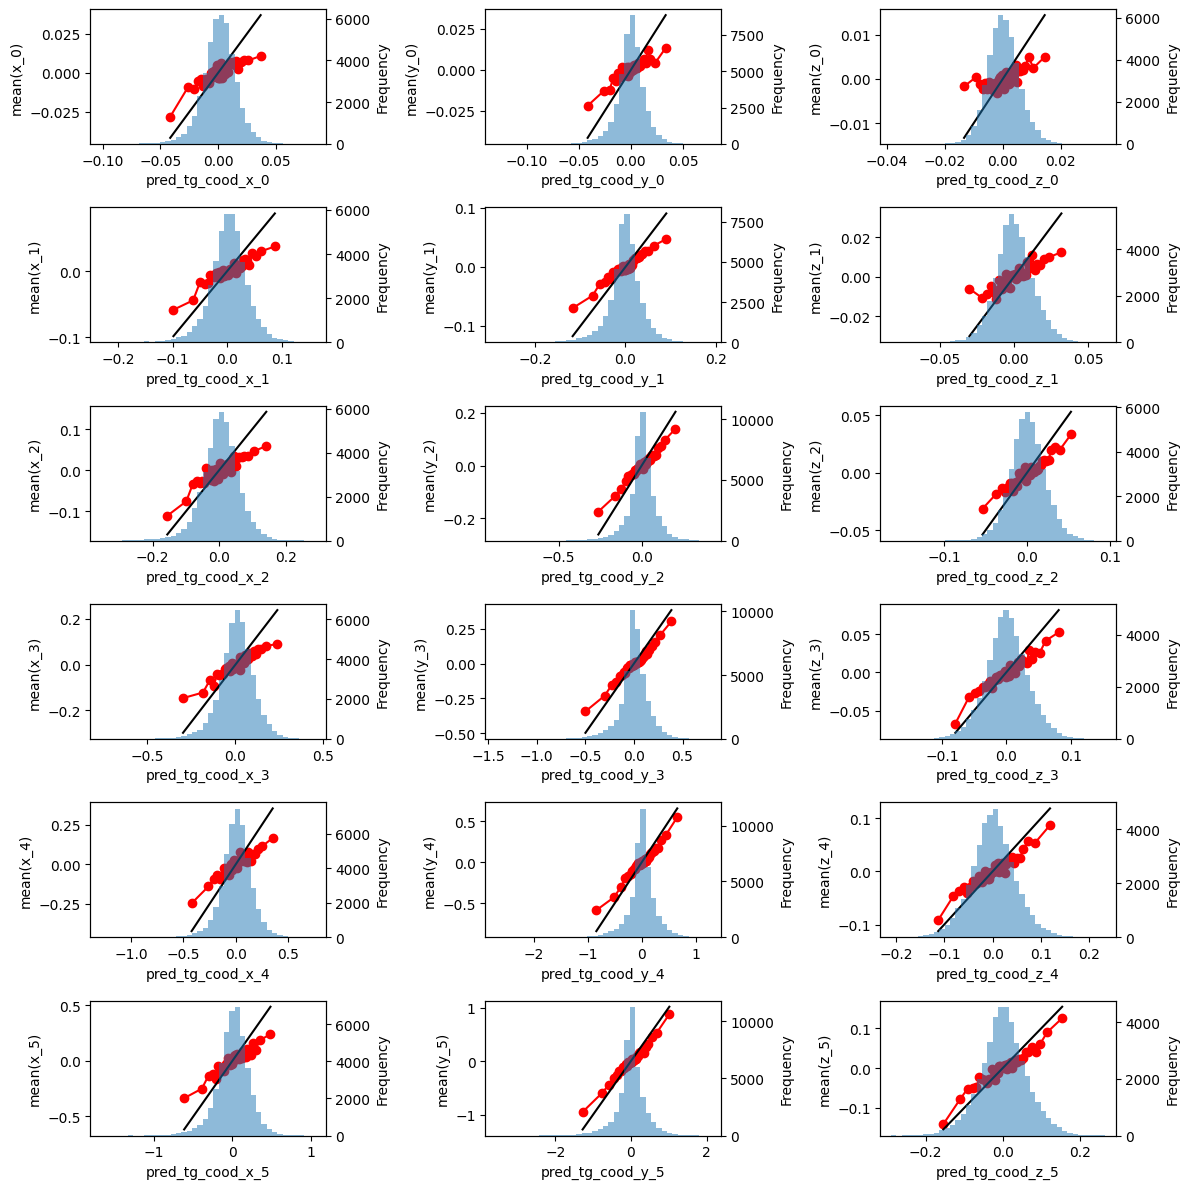

In [21]:
utils.plot_calibration_curve(tr_df, pred_cols, n_bins=40)

In [22]:
if BASE_PRED_DIR is not None:
    # 差し引いていた基礎推定値を足して元のtarget, pred列に戻す
    tr_df = add_base_pred_to_target(tr_df, TARGET_COLS)
    tr_df = add_base_pred_to_target(tr_df, pred_cols)

In [23]:
if BASE_PRED_DIR is not None:
    scores = calc_score(tr_df, pred_cols)
    display(scores)

{'score_pred_tg_cood_x_0': 0.06034458926389893,
 'score_pred_tg_cood_y_0': 0.03287366958003685,
 'score_pred_tg_cood_z_0': 0.026074048434338484,
 'score_pred_tg_cood_x_1': 0.1278075831636106,
 'score_pred_tg_cood_y_1': 0.07150835397599883,
 'score_pred_tg_cood_z_1': 0.053942238009819364,
 'score_pred_tg_cood_x_2': 0.21626806451681058,
 'score_pred_tg_cood_y_2': 0.12414490490679153,
 'score_pred_tg_cood_z_2': 0.08285021596296308,
 'score_pred_tg_cood_x_3': 0.3369864358264669,
 'score_pred_tg_cood_y_3': 0.2010826949107614,
 'score_pred_tg_cood_z_3': 0.11285538549730043,
 'score_pred_tg_cood_x_4': 0.48626979664780723,
 'score_pred_tg_cood_y_4': 0.3053761696184787,
 'score_pred_tg_cood_z_4': 0.14430824155778765,
 'score_pred_tg_cood_x_5': 0.6591647444149557,
 'score_pred_tg_cood_y_5': 0.43895885329544454,
 'score_pred_tg_cood_z_5': 0.17672754316912564,
 'avg': 0.20319686293068873}

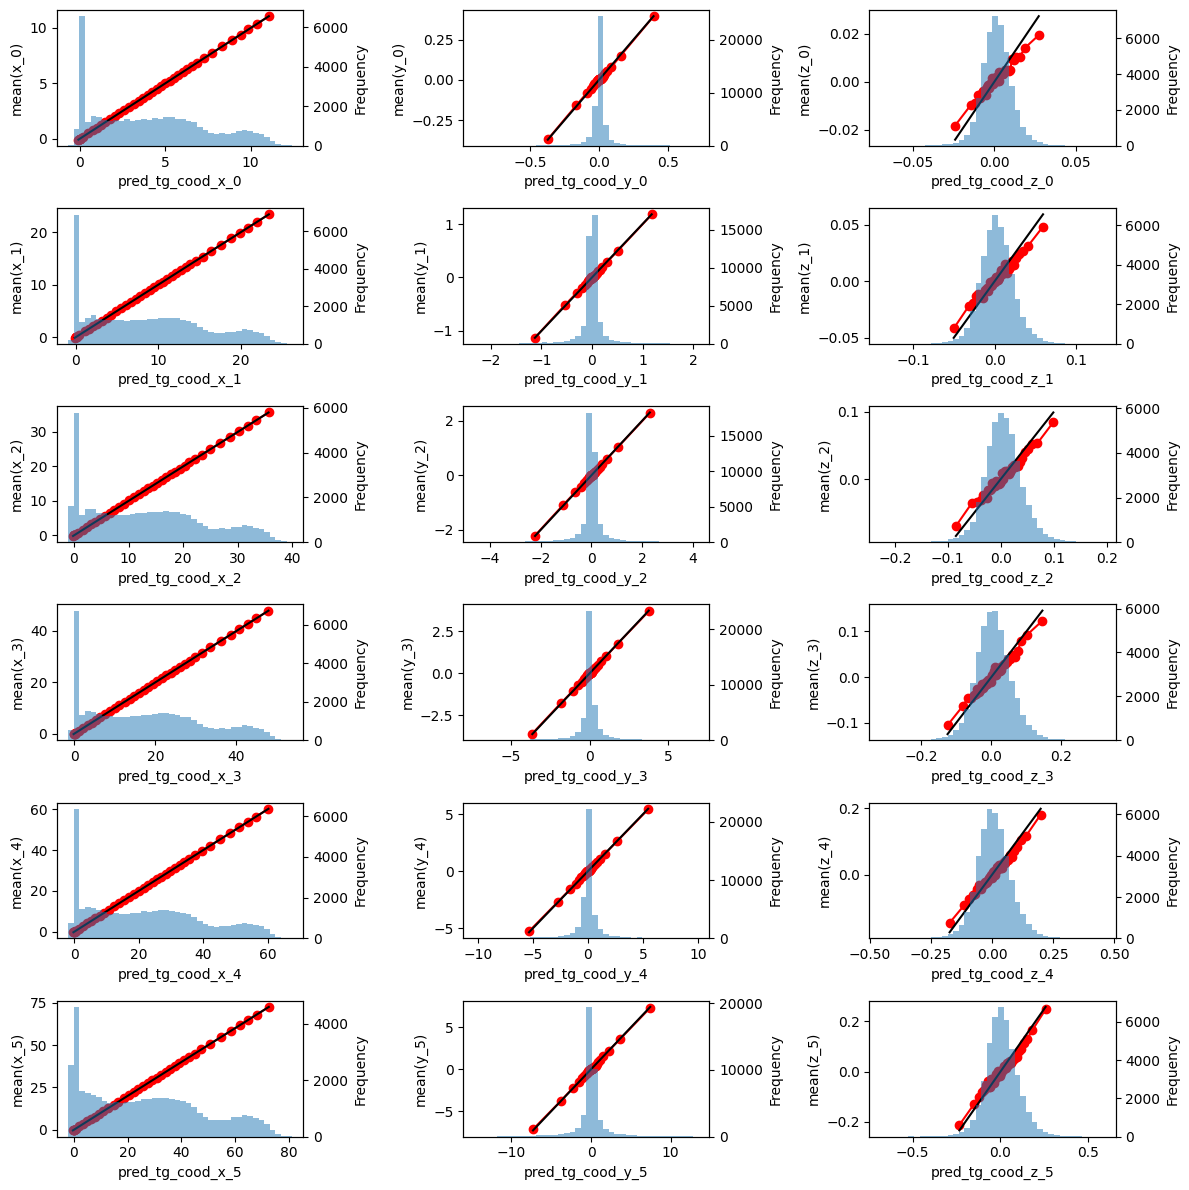

In [24]:
if BASE_PRED_DIR is not None:
    utils.plot_calibration_curve(tr_df, pred_cols, n_bins=40)

## oofを保存

In [25]:
def create_submission_csv(preds: pl.DataFrame, filename: str = "submission.csv"):
    submission_cols = TARGET_COLS

    # validate preds columns
    if len(preds.columns) != len(submission_cols):
        raise ValueError(
            f"preds columns must be {len(submission_cols)}, but got {len(preds.columns)}"
        )

    preds.columns = submission_cols
    preds.write_csv(filename)
    print(f"Submission file is created: {filename}")


# 元の順番に戻して保存
create_submission_csv(tr_df.sort("origin_idx").select(pred_cols), "oof_preds.csv")

Submission file is created: oof_preds.csv


## Submission

In [26]:
preds = utils.predict(
    models,
    ts_images,
    ts_df,
    feature.columns,
    scene_id_col="scene_id",
    scene_dsec_col="scene_dsec",
    pred_cols=pred_cols,
)
pred_cols = preds.columns
ts_df = pl.concat([ts_df, preds], how="horizontal")

preds

pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
-0.001337,0.002598,-0.003276,-0.008365,0.022525,-0.004795,0.0008,0.062286,-0.00571,-0.0082,0.111869,-0.012873,-0.046605,0.227564,-0.00619,0.040777,0.330978,-0.019338
-0.002733,0.000377,-0.002514,-0.015052,0.036587,-0.002326,-0.028955,0.082328,0.00818,-0.029721,0.170661,-0.010302,-0.079126,0.312537,-0.013414,-0.06928,0.561668,0.01574
0.007351,0.005153,-0.00112,0.006372,0.031205,-0.000363,0.009671,0.046497,-0.014137,0.050049,0.075761,0.000426,0.008916,0.118525,-0.023009,0.028176,0.213895,-0.037766
-0.038436,-0.001367,-0.003214,-0.090339,0.010888,0.007587,-0.157011,0.030497,0.000836,-0.26888,0.043859,-0.03533,-0.388191,0.106666,-0.000264,-0.646135,0.143934,-0.047584
0.0052,-0.008633,-0.002026,0.007638,-0.013129,0.003172,0.013847,-0.028983,0.005094,0.055861,-0.0268,-0.006495,0.060611,-0.032946,-0.006395,0.091293,-0.070468,-0.01461
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.004033,0.020896,-0.00482,0.034216,0.063669,-0.010751,0.07452,0.148668,-0.046423,0.117287,0.307124,-0.056383,0.217848,0.50288,-0.088781,0.281824,0.848609,-0.103802
-0.014504,0.004198,-0.010089,-0.033591,0.038927,-0.036061,-0.040446,0.106185,-0.058697,0.009703,0.179184,-0.101249,-0.030195,0.286028,-0.155289,-0.03587,0.398437,-0.20346
-0.013204,0.003859,0.001787,-0.030584,0.001156,-0.005083,-0.060367,0.041847,0.001532,-0.111469,0.084503,0.014714,-0.167735,0.143492,0.006466,-0.20503,0.221769,0.025491


In [27]:
if BASE_PRED_DIR is not None:
    # 差し引いていた基礎推定値を足して元のtarget, pred列に戻す
    ts_df = add_base_pred_to_target(ts_df, pred_cols)
    display(ts_df)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,scene_id,scene_dsec,origin_idx,base_pred_x_0,base_pred_y_0,base_pred_z_0,base_pred_x_1,base_pred_y_1,base_pred_z_1,base_pred_x_2,base_pred_y_2,base_pred_z_2,base_pred_x_3,base_pred_y_3,base_pred_z_3,base_pred_x_4,base_pred_y_4,base_pred_z_4,base_pred_x_5,base_pred_y_5,base_pred_z_5,ft_vEgo,ft_aEgo,ft_steeringAngleDeg,ft_steeringTorque,…,ft_rightBlinker,ft_base_pred_x0,ft_base_pred_y0,ft_base_pred_z0,ft_base_pred_x1,ft_base_pred_y1,ft_base_pred_z1,ft_base_pred_x2,ft_base_pred_y2,ft_base_pred_z2,ft_base_pred_x3,ft_base_pred_y3,ft_base_pred_z3,ft_base_pred_x4,ft_base_pred_y4,ft_base_pred_z4,ft_base_pred_x5,ft_base_pred_y5,ft_base_pred_z5,pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,str,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""012baccc145d400c896cb82065a93d…",3.374273,-0.01936,-34.008415,17.0,0.0,false,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",120,0,1.4928,-0.047437,-0.000326,3.122828,-0.094562,-0.003115,4.703802,-0.159459,-0.005652,6.214634,-0.190779,-0.006373,7.652307,-0.179759,-0.009369,8.970826,-0.119019,-0.007873,3.374273,-0.01936,-34.008415,17.0,…,0.0,1.4928,-0.047437,-0.000326,3.122828,-0.094562,-0.003115,4.703802,-0.159459,-0.005652,6.214634,-0.190779,-0.006373,7.652307,-0.179759,-0.009369,8.970826,-0.119019,-0.007873,1.491463,-0.044838,-0.003602,3.114463,-0.072037,-0.00791,4.704601,-0.097173,-0.011362,6.206433,-0.07891,-0.019245,7.605702,0.047805,-0.015559,9.011603,0.211959,-0.027211
"""012baccc145d400c896cb82065a93d…",2.441048,-0.022754,307.860077,295.0,0.0,true,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",220,1,0.933565,0.392385,0.000336,1.814535,1.033601,0.003623,2.47108,1.776173,0.004562,3.011575,2.673704,0.008065,3.689159,3.759892,0.017334,4.346382,5.04043,0.030237,2.441048,-0.022754,307.860077,295.0,…,0.0,0.933565,0.392385,0.000336,1.814535,1.033601,0.003623,2.47108,1.776173,0.004562,3.011575,2.673704,0.008065,3.689159,3.759892,0.017334,4.346382,5.04043,0.030237,0.930832,0.392761,-0.002178,1.799483,1.070189,0.001297,2.442125,1.858501,0.012742,2.981854,2.844365,-0.002238,3.610033,4.072429,0.00392,4.277102,5.602097,0.045977
"""012baccc145d400c896cb82065a93d…",3.604152,-0.286239,10.774388,-110.0,0.0,true,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…",320,2,1.615533,0.004321,0.00092,3.345943,-0.001811,0.000561,4.938106,-0.031779,-0.001101,6.459437,-0.012939,-0.001444,7.913136,-0.000395,-0.005522,9.219673,0.00669,-0.006699,3.604152,-0.286239,10.774388,-110.0,…,0.0,1.615533,0.004321,0.00092,3.345943,-0.001811,0.000561,4.938106,-0.031779,-0.001101,6.459437,-0.012939,-0.001444,7.913136,-0.000395,-0.005522,9.219673,0.00669,-0.006699,1.622884,0.009474,-0.0002,3.352314,0.029393,0.000198,4.947778,0.014717,-0.015237,6.509486,0.062822,-0.001018,7.922052,0.11813,-0.028531,9.247849,0.220585,-0.044465
"""012baccc145d400c896cb82065a93d…",2.048902,-0.537628,61.045235,189.0,0.0,true,0.0,false,"""drive""",true,false,"""012baccc145d400c896cb82065a93d…",420,3,0.857725,0.066614,-0.005757,1.710414,0.188786,-0.01204,2.464009,0.37251,-0.017823,3.084059,0.624366,-0.025491,3.671909,1.03626,-0.036196,4.27187,1.577337,-0.050439,2.048902,-0.537628,61.045235,189.0,…,0.0,0.857725,0.066614,-0.005757,1.710414,0.188786,-0.01204,2.464009,0.37251,-0.017823,3.084059,0.624366,-0.025491,3.671909,1.03626,-0.036196,4.27187,1.577337,-0.050439,0.819289,0.065247,

In [28]:
# 元の順番に戻す
ts_df = ts_df.sort("origin_idx")

In [29]:
create_submission_csv(ts_df.select(pred_cols), "submission.csv")

Submission file is created: submission.csv
